## Feature selection using two-stage filtering method  
We applied a two-stage filtering feature selection method for both bow and tfi-df text representation only.    
filter 1 - remove feature with low variance
filter 2 - remove redundant features using MI score   
text_bow1_kt:  

| Using all features bow1:    | LR = 0.7389736477115117 | (6459 features) |
|-----------------------------|-------------------------|-----------------|
| With our two-stage FS bow1: | LR = 0.7147018030513176 | (1394 features) |

text_bow1_ws:  

| Using all features bow1:    | LR = 0.6877531941414771 | (6459 features) |
|-----------------------------|-------------------------|-----------------|
| With our two-stage FS bow1: | LR = 0.6678092863820505 | (588 features) |


pree.t@cmu.ac.th  

In [1]:
import joblib
import os
import numpy as np
from scipy import sparse
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif

import matplotlib.pyplot as plt

os.path.dirname(os.getcwd())

model_path = os.path.dirname(os.getcwd()) + '\\model\\'
lexicon_path = os.path.dirname(os.getcwd()) + '\\lexicon\\'

In [2]:
# preparing all data that need to calculate the MI score

text_bow1_kt = joblib.load(model_path+'text_bow1_kt.pkl')
text_bow1_ws = joblib.load(model_path+'text_bow1_ws.pkl')

text_bow2_kt = joblib.load(model_path+'text_bow2_kt.pkl')
text_bow2_ws = joblib.load(model_path+'text_bow2_ws.pkl')

text_tfidf1_kt = joblib.load(model_path+'text_tfidf1_kt.pkl')
text_tfidf1_ws = joblib.load(model_path+'text_tfidf1_ws.pkl')

text_tfidf2_kt = joblib.load(model_path+'text_tfidf2_kt.pkl')
text_tfidf2_ws = joblib.load(model_path+'text_tfidf2_ws.pkl')

all_texts = [("text_bow1_kt", text_bow1_kt),
             ("text_bow1_ws", text_bow1_ws),
             ("text_bow2_kt", text_bow2_kt),
             ("text_bow2_ws", text_bow2_ws),
             ("text_tfidf1_kt", text_tfidf1_kt),
             ("text_tfidf1_ws", text_tfidf1_ws),
             ("text_tfidf2_kt", text_tfidf2_kt),
             ("text_tfidf2_ws", text_tfidf2_ws)
            ]
# lex_bow1_kt = joblib.load(lexicon_path+'lex_bow1_kt.pkl')
# lex_bow1_ws = joblib.load(lexicon_path+'lex_bow1_ws.pkl')

# lex_bow2_kt = joblib.load(lexicon_path+'lex_bow2_kt.pkl')
# lex_bow2_ws = joblib.load(lexicon_path+'lex_bow2_ws.pkl')

In [95]:
'''
parem: texts=list of text representation, 
        vt_dim= dimension for first filter,
        mi_dim = diminsion last filter
return: array 
'''
#def twosteps_fs(texts, vt_dim, mi_dim):
#    for text in texts:
X, y = text_bow1_kt
vt = VarianceThreshold()
vt.fit(X)
feature_score = vt.variances_

idx = np.flip(np.argsort(feature_scores))
tmp = np.take(X_vt, idx[0], axis=1)        
X_vt = tmp[:, :vt_dim]

#    return ""
feature_score

(6459,)

In [3]:
X, y = text_bow1_kt
X = X.A
y = y.A

print(X.shape)
print(y.shape)

(60081, 6459)
(60081, 1)


## Filter 1 - remove features with low variance

In [4]:
# bow1_kt 0.00035
# bow1_ws 0.003
# bow2_kt 0.00065
# bow2_ws
# tfidf1_kt
# tfidf1_ws
# tfidf2_kt
# tfidf2_ws
threshold_val = 0.00035
vt = VarianceThreshold(threshold=threshold_val)
vt.fit(X)
mask = vt.get_support()

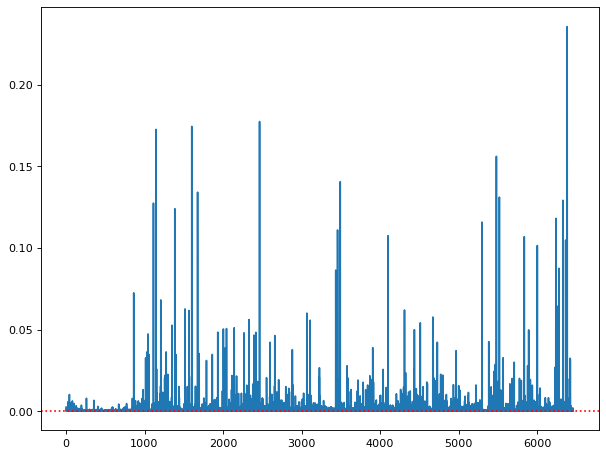

In [5]:
fig = plt.figure(figsize=(9, 7), dpi=80) 
ax = plt.axes()
ax.plot(vt.variances_)
ax.axhline(threshold_val, ls='dotted', c='r');

In [6]:
idx = np.where(mask==False)
print("total number of feature will be removed:", len(idx[0]))
X_vt =  np.delete(X, idx, 1)
X_vt.shape

total number of feature will be removed: 3755


(60081, 2704)

## Filter 2 remove using MI score

In [7]:
#calcuate mi score of the remaining terms
feature_scores = mutual_info_classif(X_vt, np.ravel(y), random_state=0)

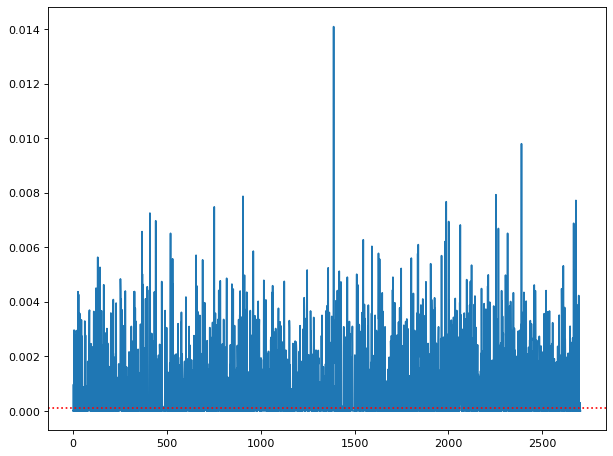

In [22]:
# bow1_kt = 0.0001
# bow1_ws = 0.0005
mi_threshold_val = 0.0001

fig = plt.figure(figsize=(9, 7), dpi=80) 
ax = plt.axes()
ax.plot(feature_scores)
ax.axhline(mi_threshold_val, ls='dotted', c='r');

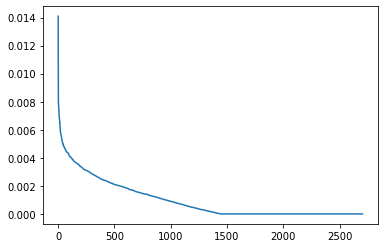

In [23]:
# set another mi score threshold manually, so that we can have reasonable size
plt.plot(-np.sort(-feature_scores))

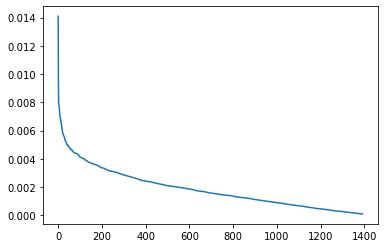

In [24]:
feature_scores_final = feature_scores[feature_scores > mi_threshold_val]
plt.plot(-np.sort(-feature_scores_final))

In [25]:
# select with threashold
# mi_idx = np.argwhere(feature_scores > mi_threshold_val)
# X_vt_mi = np.take(X_vt, mi_idx.flatten(), axis=1)
# X_vt_mi.shape

(60081, 1393)

In [84]:
# select with fix dimension (i.e., 500)
dim = 600
mi_idx = np.flip(np.argsort(feature_scores))
tmp = np.take(X_vt, mi_idx.flatten(), axis=1)        
X_vt_mi = tmp[:, :dim]
X_vt_mi.shape

(60081, 600)

In [85]:
arr_new = np.hstack((sparse.csr_matrix(X_vt_mi), sparse.csr_matrix(y)))
joblib.dump(arr_new, model_path+'text_bow1_ws_kt.pkl')

['C:\\Users\\Pree\\Thai_SA_journal\\model\\text_bow1_ws_kt.pkl']

## Test with LR

In [86]:
#arr = np.concatenate((X, y), axis=1)
arr_fs = np.concatenate((X_vt_mi, y), axis=1)


In [87]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

In [88]:
train_df, test_df = train_test_split(arr_fs, test_size=0.20, random_state=42)
train_df.shape, test_df.shape

((48064, 601), (12017, 601))

In [89]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df[:,:-1], train_df[:,-1], test_size=0.15, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((40854, 600), (7210, 600), (40854,), (7210,))

In [90]:
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train, y_train)
round(model.score(X_valid, y_valid), 4)

0.701